In [1]:
expid='MC_O_20251103_000421'
sensor='R40_SG0'

In [2]:
from lsst.resources import ResourcePath
from astropy.io import fits
import numpy
from astropy.table import Table
from dateutil.parser import parse
import matplotlib.pyplot as plt
from astropy.stats import mad_std
from lsst.daf.butler import Butler
from astropy.io import fits

butler = Butler('embargo', collections=['LSSTCam/raw/all', 'LSSTCam/raw/guider'])
detector=list(butler.registry.queryDimensionRecords("detector",instrument='LSSTCam',where=f"detector.full_name='{sensor}'"))[0].id



INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/y/youtsumi/.lsst/aws-credentials.ini


In [3]:
def examineone(expid,sensor):
    detector=list(butler.registry.queryDimensionRecords("detector",instrument='LSSTCam',where=f"detector.full_name='{sensor}'"))[0].id
    path=butler.getURI('guider_raw',instrument='LSSTCam',detector=detector,exposure=expid).geturl()
    print(path)
    rp=ResourcePath(path)
    with rp.open(mode="rb") as f:
        hdu_list = fits.open(f)
#    hdus = hdu_list[2::2]  # for thek mode with raw stamps
    hdus = hdu_list[1:-2]   # for the mode without raw stamps
    try:
        timing = [ parse(hdu.header['STMPTIME']) for hdu in hdus ]
    except:
        timing = [  numpy.nan for hdu in hdus ]
    try:
        mean = [ numpy.mean(hdu.data) for hdu in hdus ]
    except:
        mean = [ numpy.nan for hdu in hdus ]
    try:
        stdnoise = numpy.mean(list(map( lambda x: mad_std(x.data[1:-1,1:-1]), hdus))) 
    except:
        raise
    try:
        stdstdnoise = numpy.std(list(map( lambda x: mad_std(x.data[1:-1,1:-1]), hdus))) 
    except:
        stdstdnoise = numpy.nan
    try:
        hz = 1/numpy.array(list(map(lambda x: x.total_seconds(), numpy.diff(numpy.array(list(map( lambda x: parse(x.header['STMPTIME']), hdus) )[1:]))))).mean()
    except:
        hz = numpy.nan

    return {
        's3path': rp,
        'basename': rp.abspath().basename(),
        'noise': stdnoise,
        'std(noise)': stdstdnoise,        
        'Hz': hz,
        'mean': mean,
        'timing': timing
    }
    

In [4]:
table=Table(
    list(map( lambda x: examineone(expid, x), [
        'R00_SG0',
        'R00_SG1',
        'R04_SG0',
        'R04_SG1',
        'R40_SG0',
        'R40_SG1',
        'R44_SG0',
        'R44_SG1'
    ])
       )
)
table['basename','noise','std(noise)','Hz' ] # ,'mean','timing']

s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R00_SG0_guider.fits
s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R00_SG1_guider.fits
s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R04_SG0_guider.fits
s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R04_SG1_guider.fits
s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R40_SG0_guider.fits
s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R40_SG1_guider.fits
s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R44_SG0_guider.fits
s3://embargo@rubin-summit/LSSTCam/20251103/MC_O_20251103_000421/MC_O_20251103_000421_R44_SG1_guider.fits


basename,noise,std(noise),Hz
str40,float64,float64,float64
MC_O_20251103_000421_R00_SG0_guider.fits,8.984569444143949,0.46032351690287276,1.6759191369016444
MC_O_20251103_000421_R00_SG1_guider.fits,7.531619270008457,0.5810590282971293,1.6759191369016444
MC_O_20251103_000421_R04_SG0_guider.fits,8.361876512371596,0.8260103743984237,1.6759191369016444
MC_O_20251103_000421_R04_SG1_guider.fits,7.472315181268234,0.29052951414856454,1.6759191369016444
MC_O_20251103_000421_R40_SG0_guider.fits,9.043873532884174,0.8516901324101691,1.6759191369016444
MC_O_20251103_000421_R40_SG1_guider.fits,7.561271314378571,0.8516901324101691,1.6759191369016444
MC_O_20251103_000421_R44_SG0_guider.fits,7.41301109252801,0.7263237853714113,1.6759191369016444
MC_O_20251103_000421_R44_SG1_guider.fits,7.531619270008457,0.652344976142465,1.6759191369016444


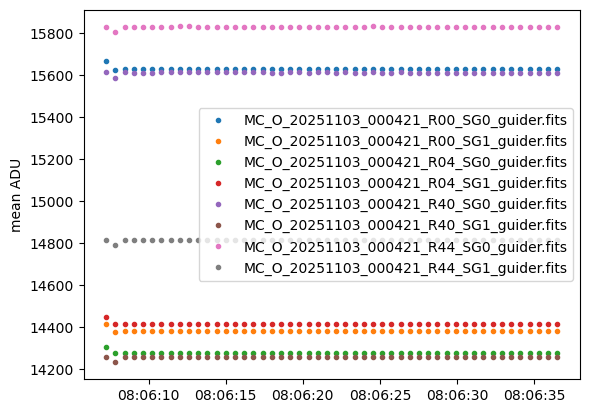

In [5]:
for row in table:
    plt.plot(row['timing'],row['mean'],'.',label=row['basename'])
plt.ylabel('mean ADU')
plt.legend()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 8.333333333333334 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /lscratch/youtsumi/tmpf3fs16dd/temp.m4v


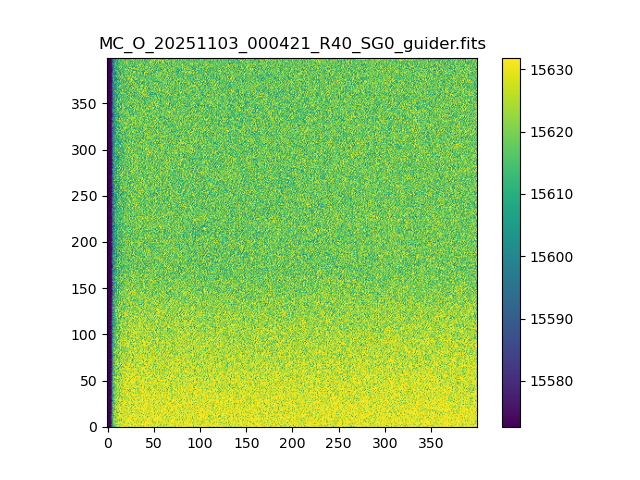

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from IPython.display import HTML
import numpy as np
%matplotlib widget

detector=list(butler.registry.queryDimensionRecords("detector",instrument='LSSTCam',where=f"detector.full_name='{sensor}'"))[0].id
path=butler.getURI('guider_raw',instrument='LSSTCam',detector=detector,exposure=expid).geturl()
s3file=ResourcePath(path)
with s3file.open(mode='rb') as f:
    fh = fits.open(f)

fig, ax = plt.subplots()
plt.clf()

frames = []
#zscale = ZScaleInterval()
img=fh[2].data
std=mad_std(img)
N=3
vmin, vmax = img.mean()-std, img.mean()+N*std # zscale.get_limits(fh[2].data)

frames = [[plt.imshow(img.data, animated=True, vmin=vmin, vmax=vmax, origin='lower')] for img in fh[1::-2]]

plt.colorbar()
plt.title(s3file.basename())
ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())
#plt.show()

In [7]:
#with s3file.open(mode="r") as f:
#    j=json.load(f)
#print(json.dumps(j,indent=2))